In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sqlite3
import seaborn as sns
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle


In [39]:
nltk.download('stopwords')
nltk.download('punkt')
arabic_stopwords = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ibrahim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ibrahim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
! pip install pyarabic

In [41]:
database_file = 'dialects_database.db'
conn = sqlite3.connect(database_file)

In [42]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

In [43]:
dataframes = {}
for table in tables['name']:
    dataframes[table] = pd.read_sql(f"SELECT * FROM {table}", conn)
    

In [44]:
dataframes.keys()

dict_keys(['id_text', 'id_dialect'])

In [45]:
df = pd.merge(dataframes['id_text'],dataframes['id_dialect'],on='id')
df

,id,text,dialect
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY
...,...,...,...
147720,982775354405376000,الناس دي بتنفخ في قربة مقدودة بالدارجي كده ال...,SD
147721,980728852224860160,@Wail_Hamza @amiromer انت عايش وين بره السودان...,SD
147722,975502734668500992,مااحرم نفسي ميسي حريف ولعاب برضو ..\nمدريدي وا...,SD
147723,980207908641263616,ياخي ديل ماخلو للشيطان وإبليس شي لكن يروحو وي...,SD


In [46]:
df.head()

,id,text,dialect
0,1009754958479151232,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,LY
1,1009794751548313600,@AlmFaisal 😂😂 الليبيين متقلبين!!!\nبس بالنسبة ...,LY
2,1019989115490787200,@smsm071990 @ALMOGRBE كل 20 تانيه شاب ليبي بير...,LY
3,1035479791758135168,@AboryPro @lyranoo85 رانيا عقليتك متخلفة. اولا...,LY
4,1035481122921164800,@lyranoo85 شكلك متعقدة علشان الراجل لي تحبيه ا...,LY


<Axes: xlabel='dialect', ylabel='count'>

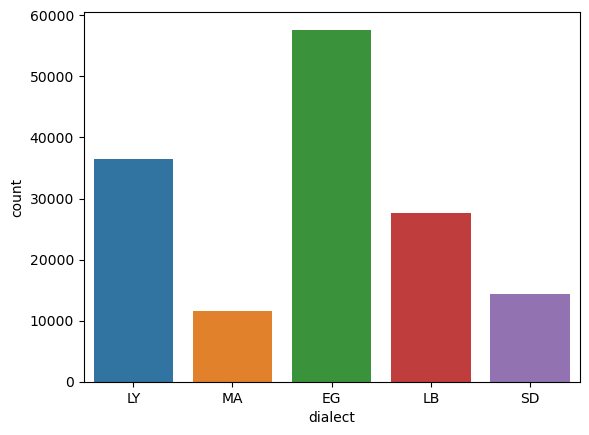

In [47]:
sns.countplot(x='dialect',data=df)

In [48]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "["                       # Start of pattern
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & pictographs
        "\U0001F680-\U0001F6FF"  # Transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002700-\U000027BF"  # Dingbats
        "\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE   # End of pattern
    )
    return emoji_pattern.sub(r'', text)

# Function to normalize Arabic text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

# Function to remove diacritics
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    return re.sub(arabic_diacritics, '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_non_arabic(text):
    return re.sub(r'[^\u0621-\u064A\s]', '', text)

def remove_english(text):
    return re.sub(r'[a-zA-Z]', '', text)

In [49]:
def preprocess_text(text):
    # Remove emojis
    text = remove_emojis(text)
    
    text = remove_mentions(text)
    
    text = remove_hashtags(text)
    
    text = remove_urls(text)
    
    text = remove_non_arabic(text)
    
    text = remove_english(text)
    
    # Normalize the text
    text = normalize_arabic(text)
    
    # Remove punctuation and symbols
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove diacritics
    text = remove_diacritics(text)
    
    # Tokenize
    words = word_tokenize(text)
    
    # Remove stop words
    words = [word for word in words if word not in arabic_stopwords]
    
    return ' '.join(words)

In [50]:
df['text'] = df['text'].apply(preprocess_text)

In [51]:
df.head()

,id,text,dialect
0,1009754958479151232,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...,LY
1,1009794751548313600,الليبيين متقلبين بالنسبه ليا انا ميليشياوي زما...,LY
2,1019989115490787200,تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها ...,LY
3,1035479791758135168,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل...,LY
4,1035481122921164800,شكلك متعقده علشان الراجل تحبيه ازوج بنت يتيمه ...,LY


In [52]:
lenghts = [len(text) for text in df['text']]

c:\Users\ibrahim\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

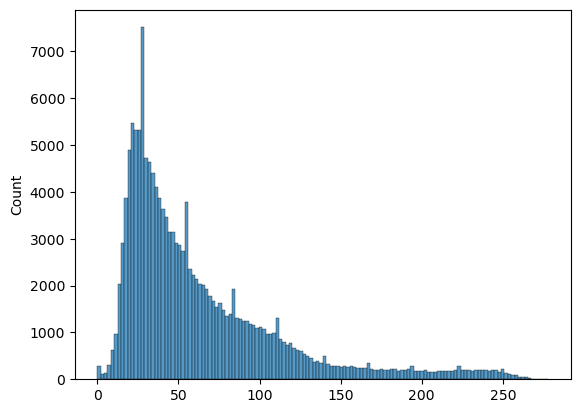

In [53]:
sns.histplot(lenghts)

In [54]:
df = df.drop('id',axis=1)

In [55]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['text'])
y = df['dialect']

In [56]:
from sklearn.preprocessing import LabelEncoder

In [57]:
le = LabelEncoder()
y = le.fit_transform(y)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


model = LogisticRegression(max_iter=1000)


model.fit(x_train, y_train)

# make predictions
y_pred = model.predict(x_test)

# calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# calculate the f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.8060924014215604
F1 Score: 0.8003292965461134


In [60]:
df.head()

,text,dialect
0,قليلين ادب ومنافقين اختهم او قريبتهم تتعاكس تق...,LY
1,الليبيين متقلبين بالنسبه ليا انا ميليشياوي زما...,LY
2,تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها ...,LY
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل...,LY
4,شكلك متعقده علشان الراجل تحبيه ازوج بنت يتيمه ...,LY


In [61]:
df['dialect'].value_counts()

dialect
EG    57636
LY    36499
LB    27617
SD    14434
MA    11539
Name: count, dtype: int64

In [62]:
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
pickle.dump(le, open('le.pkl', 'wb'))

In [63]:
model = pickle.load(open('model.pkl', 'rb'))
tfidf = pickle.load(open('tfidf.pkl', 'rb'))
le = pickle.load(open('le.pkl', 'rb'))

In [67]:
def predict(text):
    text = preprocess_text(text)
    text = tfidf.transform([text])
    return le.inverse_transform(model.predict(text))[0]

In [72]:
predict('كغو عليك')

'LY'